# Movie Recommender System

In [3]:
import numpy as np
import pandas as pd

Read in the data

In [4]:
cols = ['user_id', 'item_id', 'rating', 'timestamp']

In [5]:
df = pd.read_csv('ml-100k/u.data', sep='\t', names=cols)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
titles = pd.read_csv('ml-100k/Movie_Id_Titles')
titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Mergeing the data

In [7]:
df = pd.merge(df,titles, on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


A look at number of unique users and movies

In [8]:
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()
print(n_users)
n_items

943


1682

## Exploratory Data Analysis

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [10]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

In [11]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             583
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

Lets create a dataframe with average rating and number of ratings

In [12]:
ratings =pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [13]:
ratings['rating_numbers'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,rating_numbers
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


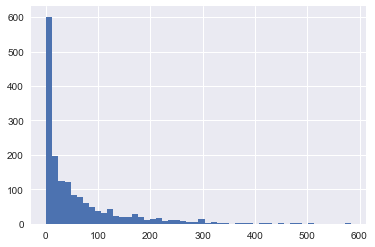

In [14]:
ratings['rating_numbers'].hist(bins=50)

             Number of ratings

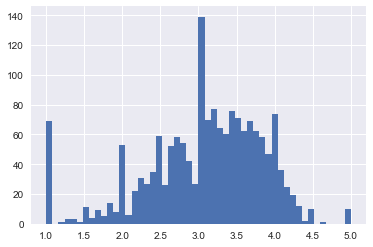

In [15]:
ratings['rating'].hist(bins=50)

        Average rating per movie

Lets now split the data into train and test segments of 75% and 25%

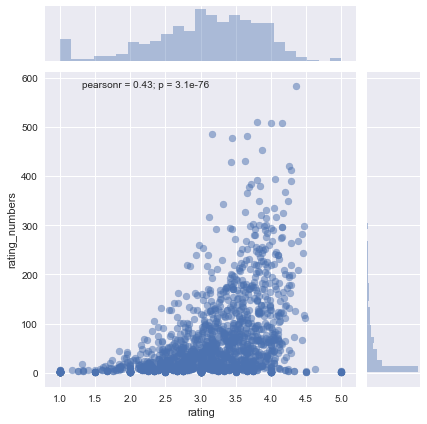

In [16]:
sns.jointplot(x='rating', y='rating_numbers', data=ratings, alpha=0.5)

        Number of ratings vs average ratings

In [17]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.25)

## Memory-Based Collaborative Filtering
Memory based collaborative filtering consists of 2 steps: user-item filtering and item-item filtering.
A user-item filtering will take a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked.
In contrast, item-item filtering will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations.

Lets create two user-item matrices, one for training and another for testing

In [18]:
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

Lets see what the cosine similarity looks like for users and items

In [20]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')
print(user_similarity)
item_similarity

[[ 0.          0.86176235  0.94976094 ...,  0.87099517  0.8272511
   0.65637395]
 [ 0.86176235  0.          0.91945532 ...,  0.83109974  0.93641739
   0.9269512 ]
 [ 0.94976094  0.91945532  0.         ...,  0.88226369  0.95521041
   0.96720083]
 ..., 
 [ 0.87099517  0.83109974  0.88226369 ...,  0.          0.90917034
   0.91473646]
 [ 0.8272511   0.93641739  0.95521041 ...,  0.90917034  0.          0.8295889 ]
 [ 0.65637395  0.9269512   0.96720083 ...,  0.91473646  0.8295889   0.        ]]


array([[ 0.        ,  0.69975717,  0.75617729, ...,  1.        ,
         0.9460542 ,  1.        ],
       [ 0.69975717,  0.        ,  0.75158037, ...,  1.        ,
         0.91118661,  1.        ],
       [ 0.75617729,  0.75158037,  0.        , ...,  1.        ,
         1.        ,  1.        ],
       ..., 
       [ 1.        ,  1.        ,  1.        , ...,  0.        ,
         1.        ,  1.        ],
       [ 0.9460542 ,  0.91118661,  1.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  0.        ]])

Lets start mnaking predictions

In [21]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [22]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

In [23]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [24]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 3.1233717692496152
Item-based CF RMSE: 3.4509548767561133


## Model Based Collaborative Filtering

Model based collaborative filtering implements matrix factorization to learn latent preferences of users and attributes of items from known ratings. Model based CF tends to outperform Memory based CF. SVD is a great matrix factorization method which is widely used for collaborative filtering.

In [25]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix)))

User-based CF MSE: 2.7193491275211157
